In [232]:
import pandas as pd
import numpy as np

import geopandas as gpd
import geopandas.tools as gdp_tools
from shapely.geometry import shape, Point, Polygon
import fiona

import json

In [233]:
DATA_LOC ='./data/2020/'
DATA_BASE ='./data/'

In [234]:
#file = DATA_LOC + 'Basisdata_0000_Norge_25833_N2000Kartdata_FGDB/Basisdata_0000_Norge_25833_N2000Kartdata_FGDB.gdb'
file = DATA_LOC + 'Basisdata_0000_Norge_25833_N2000Kartdata_FGDB.gdb'

for i, name in enumerate(fiona.listlayers(file)):
       print(name)
       if name == 'N2000_AdministrativeOmråder_omrade':
           with fiona.open(file, layer=i) as layer:
              for feature in layer:
                 objtype = (feature['properties']['objtype'])
                 if objtype != 'Kommune':
                    print(objtype)

N2000_Samferdsel_senterlinje
N2000_Arealdekke_omrade
N2000_Arealdekke_grense
N2000_Arealdekke_senterlinje
N2000_AdministrativeOmråder_grense
N2000_Høyde_senterlinje
N2000_Høyde_omrade
N2000_AdministrativeOmråder_omrade
N2000_Arealdekke_posisjon
N2000_Restriksjonsområder_grense
N2000_Restriksjonsområder_omrade
N2000_BygningerOgAnlegg_posisjon
N2000_Samferdsel_posisjon
N2000_Stedsnavn_tekstplassering
N2000_Høyde_posisjon


In [235]:
kommuner = []
for i, name in enumerate(fiona.listlayers(file)):
       if name == 'N2000_AdministrativeOmråder_omrade':
           with fiona.open(file, layer=i) as layer:
              for feature in layer:
                 if feature['properties']['objtype'] == 'Kommune':
                     kommuner.append({'name': feature['properties']['navn'],
                                      'knr' : feature['properties']['kommunenummer'],
                                      'date' : feature['properties']['oppdateringsdato'],
                                      'geometry' : shape(feature['geometry'])
                                     })   

            
df = pd.DataFrame(kommuner)

In [236]:
df.head(1)

,date,geometry,knr,name
0,2019-10-28T00:00:00,(POLYGON ((273359.4100000001 6815247.350000001...,3440,Øyer


In [237]:
df[df['name']=='Oslo']

,date,geometry,knr,name
239,2019-10-28T00:00:00,"(POLYGON ((257690.7300000004 6674315.02, 25830...",0301,Oslo


In [238]:
len(df['knr'].unique())

356

In [239]:
df['knr'].str[0:2].unique()

array(['34', '46', '15', '50', '18', '54', '30', '11', '38', '42', '03'],
      dtype=object)

In [240]:
admin_omrade = []
havflate = []
grenser = []
kontur = []
typer = []
territorialgrense = []

for i, name in enumerate(fiona.listlayers(file)):
        if name == 'N2000_AdministrativeOmråder_omrade':
            with fiona.open(file, layer=i) as layer:
                for feature in layer: 
                    if (feature['properties']['objtype'] in ('Kommune', 'Fylke')):
                        admin_omrade.append({'id': feature['id'],
                                     'type': feature['properties']['objtype'],
                                     'navn': feature['properties']['navn'],
                                     'kommunenummer' : feature['properties']['kommunenummer'],
                                     'oppdateringsdato' : feature['properties']['oppdateringsdato'],
                                  'geometry' : shape(feature['geometry'])
                                 })
        
        if name == 'N2000_Arealdekke_omrade':
            with fiona.open(file, layer=i) as layer:
                for feature in layer: 
                    if (feature['properties']['objtype'] == 'Havflate'):
                         havflate.append({'id': feature['id'],
                                     'type': feature['properties']['objtype'],
                                     'geometry' : shape(feature['geometry'])
                                 })
                            
        if name == 'N2000_Arealdekke_grense':
            with fiona.open(file, layer=i) as layer:
                for feature in layer:
                     if (feature['properties']['objtype'] in ('FiktivDelelinje', 'Kystkontur')):
                        kontur.append({ 'id' : feature['id'],
                                      'geometry' : shape(feature['geometry'])
                                     })

                            
        if name == 'N2000_AdministrativeOmråder_grense':
            with fiona.open(file, layer=i) as layer:
                for feature in layer:
                    if feature['properties']['objtype'] not in typer:
                        typer.append(feature['properties']['objtype'])
                    if (feature['properties']['objtype'] in ('Fylkesgrense', 'Riksgrense')):
                        grenser.append({ 'id' : feature['id'],
                                      'geometry' : shape(feature['geometry'])
                                     })
                    if (feature['properties']['objtype'] in ('Territorialgrense')):
                        territorialgrense.append({ 'id' : feature['id'],
                                      'geometry' : shape(feature['geometry'])
                                     })
                        


dfg = pd.DataFrame(grenser)
dft = pd.DataFrame(territorialgrense)
dfk = pd.DataFrame(kontur)

In [241]:
area = gpd.GeoDataFrame(pd.DataFrame(admin_omrade))
sea = gpd.GeoDataFrame(pd.DataFrame(havflate))
land = gpd.overlay(area, sea, how='difference')

In [242]:
kommuner=land['navn'].unique()

geoJSON=dict(type= 'FeatureCollection', 
             features = [])

for index, row in land.iterrows():
    geo_feature = dict(id=index, type= "Feature")
    geo_feature['properties'] = {'navn': row['navn']}
    geo_feature['id']=row['id']
    geo_feature['geometry'] = row['geometry'].__geo_interface__
    geoJSON['features'].append(geo_feature) 

In [243]:
sources=[]
for feat in geoJSON['features']: 
        sources.append({"type": "FeatureCollection", 'features': [feat]})

In [244]:
len(sources)

357

In [245]:
land.crs = dict(ellps='WGS84', datum='WGS84', proj='utm', zone=33, units='m', no_defs=True)
land = land.to_crs(dict(ellps='WGS84', datum='WGS84', proj='lonlat', units='km', no_defs=True))
land['centroid'] = land.centroid
land['area'] = land.area

In [246]:
land.head()

,geometry,id,kommunenummer,navn,oppdateringsdato,type,centroid,area
0,"POLYGON ((10.75339537735461 61.40471693718951,...",1,3440,Øyer,2019-10-28T00:00:00,Kommune,POINT (10.53649108196032 61.31988921668867),0.106971
1,"POLYGON ((11.79655960593511 61.46507411445239,...",2,3422,Åmot,2019-10-28T00:00:00,Kommune,POINT (11.50033806120372 61.25523976584466),0.224069
2,"POLYGON ((8.381083915327569 61.41606925622575,...",3,3454,Vang,2019-10-28T00:00:00,Kommune,POINT (8.474946064953523 61.21812702837198),0.251532
3,(POLYGON ((5.982550696146937 61.28794201280304...,4,4638,Høyanger,2019-10-28T00:00:00,Kommune,POINT (5.925425404699754 61.13898227309647),0.167109
4,"POLYGON ((8.781555946308821 61.45071867406593,...",5,3453,Øystre Slidre,2019-10-28T00:00:00,Kommune,POINT (9.097264267667597 61.24489324903831),0.160992


In [247]:
land[land['navn']=='Oslo']

,geometry,id,kommunenummer,navn,oppdateringsdato,type,centroid,area
239,"POLYGON ((10.63605582795066 60.13375192234339,...",240,0301,Oslo,2019-10-28T00:00:00,Kommune,POINT (10.73986591544763 59.98190898291021),0.072515


In [248]:
bg = land.copy()

In [249]:
class jsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, Point):
            obj = [obj.coords[0][0], obj.coords[0][1]]
        else:
            obj = super(jsonEncoder, self).default(obj)
        return obj

In [250]:
from shapely.ops import cascaded_union
def combineGeoms(*geoms):
    return cascaded_union([
        geom if geom.is_valid else geom.buffer(0) for geom in geoms
    ])

In [251]:
bg_exp = bg[['kommunenummer','oppdateringsdato','navn','geometry']].copy().explode()
bg_exp['area'] = bg_exp.area

In [252]:
bg_filt = bg_exp[bg_exp['area'] > 0.001]

In [253]:
def groupGeoms(*rows):
    for row in rows:
        geom = row['geometry']
        return(combineGeoms(*geom))

bg_comb = bg_filt[['kommunenummer','oppdateringsdato', 'navn','geometry']].groupby(['kommunenummer', 'oppdateringsdato','navn']).apply(lambda x: groupGeoms(x)).reset_index(name='geometry')

In [254]:
bg_combg = gpd.GeoDataFrame(bg_comb)
bg_combg['area_kommune'] = bg_combg.area
bg_combg['centroid_kommune'] = bg_combg.centroid
bg_combg['fylke_nummer'] = bg_combg['kommunenummer'].apply(lambda x: x[0:2])
bg_combg.head()

,kommunenummer,oppdateringsdato,navn,geometry,area_kommune,centroid_kommune,fylke_nummer
0,0301,2019-10-28T00:00:00,Oslo,"POLYGON ((10.63605582795066 60.13375192234339,...",0.072515,POINT (10.73986591544763 59.98190898291021),03
1,1101,2019-10-28T00:00:00,Eigersund,(POLYGON ((5.876816610090091 58.42534823517242...,0.066024,POINT (6.140947369482144 58.50157420291023),11
2,1103,2019-10-28T00:00:00,Stavanger,"(POLYGON ((5.74912579368547 58.88467975716248,...",0.032018,POINT (5.813980981163446 59.11581611764877),11
3,1106,2019-10-28T00:00:00,Haugesund,"POLYGON ((5.239613639164054 59.50250537386434,...",0.010756,POINT (5.302926031108083 59.4478551350085),11
4,1108,2019-10-28T00:00:00,Sandnes,(POLYGON ((6.100411887943214 58.86604901450539...,0.161279,POINT (6.319274262192941 58.97915450977888),11


In [255]:
bg_combg[bg_combg['navn']=='Vang']

,kommunenummer,oppdateringsdato,navn,geometry,area_kommune,centroid_kommune,fylke_nummer
184,3454,2019-10-28T00:00:00,Vang,"POLYGON ((8.381083915327569 61.41606925622575,...",0.251532,POINT (8.474946064953523 61.21812702837198),34


In [256]:
regioner = pd.read_csv(DATA_BASE + 'kommune_regionsendringer_2020.csv', sep=';')
regioner['fylke_nummer_2019'] = regioner['Fylke 2019'].apply(lambda x: x[0:2])
regioner['fylke_navn_2019'] = regioner['Fylke 2019'].apply(lambda x: x[3:])
regioner['fylke_nummer_2020'] = regioner['Fylke 2020'].apply(lambda x: x[0:2])
regioner['fylke_navn_2020'] = regioner['Fylke 2020'].apply(lambda x: x[3:])
regioner['kommune_nummer_2019'] = regioner['Kommune 2019'].apply(lambda x: x[0:4])
regioner['kommune_navn_2019'] = regioner['Kommune 2019'].apply(lambda x: x[5:])
regioner['kommune_nummer_2020'] = regioner['Kommune 2020'].apply(lambda x: x[0:4])
regioner['kommune_navn_2020'] = regioner['Kommune 2020'].apply(lambda x: x[5:])
regioner.rename(columns=lambda x: x.lower().replace(' ','_'), inplace=True)
regioner.head()

,fylke_2019,kommune_2019,fylke_2020,kommune_2020,fylke_nummer_2019,fylke_navn_2019,fylke_nummer_2020,fylke_navn_2020,kommune_nummer_2019,kommune_navn_2019,kommune_nummer_2020,kommune_navn_2020
0,01 ØSTFOLD,0101 HALDEN,30 VIKEN,3001 HALDEN,01,ØSTFOLD,30,VIKEN,0101,HALDEN,3001,HALDEN
1,01 ØSTFOLD,0104 MOSS,30 VIKEN,3002 MOSS,01,ØSTFOLD,30,VIKEN,0104,MOSS,3002,MOSS
2,01 ØSTFOLD,0136 RYGGE,30 VIKEN,3002 MOSS,01,ØSTFOLD,30,VIKEN,0136,RYGGE,3002,MOSS
3,01 ØSTFOLD,0105 SARPSBORG,30 VIKEN,3003 SARPSBORG,01,ØSTFOLD,30,VIKEN,0105,SARPSBORG,3003,SARPSBORG
4,01 ØSTFOLD,0106 FREDRIKSTAD,30 VIKEN,3004 FREDRIKSTAD,01,ØSTFOLD,30,VIKEN,0106,FREDRIKSTAD,3004,FREDRIKSTAD


In [257]:
fylker = regioner[['fylke_nummer_2019','fylke_navn_2019', 'fylke_nummer_2020','fylke_navn_2020']].drop_duplicates()

In [258]:
regioner[(regioner['kommune_nummer_2019']>='5030') & (regioner['kommune_nummer_2019']<='5060')]

,fylke_2019,kommune_2019,fylke_2020,kommune_2020,fylke_nummer_2019,fylke_navn_2019,fylke_nummer_2020,fylke_navn_2020,kommune_nummer_2019,kommune_navn_2019,kommune_nummer_2020,kommune_navn_2020
295,50 TRØNDELAG,5030 KLÆBU,50 TRØNDELAG,5001 TRONDHEIM,50,TRØNDELAG,50,TRØNDELAG,5030,KLÆBU,5001,TRONDHEIM
297,50 TRØNDELAG,5039 VERRAN,50 TRØNDELAG,5006 STEINKJER,50,TRØNDELAG,50,TRØNDELAG,5039,VERRAN,5006,STEINKJER
299,50 TRØNDELAG,5040 NAMDALSEID,50 TRØNDELAG,5007 NAMSOS,50,TRØNDELAG,50,TRØNDELAG,5040,NAMDALSEID,5007,NAMSOS
300,50 TRØNDELAG,5048 FOSNES,50 TRØNDELAG,5007 NAMSOS,50,TRØNDELAG,50,TRØNDELAG,5048,FOSNES,5007,NAMSOS
313,50 TRØNDELAG,5050 VIKNA,50 TRØNDELAG,5060 NÆRØYSUND,50,TRØNDELAG,50,TRØNDELAG,5050,VIKNA,5060,NÆRØYSUND
314,50 TRØNDELAG,5051 NÆRØY,50 TRØNDELAG,5060 NÆRØYSUND,50,TRØNDELAG,50,TRØNDELAG,5051,NÆRØY,5060,NÆRØYSUND


In [259]:
fylker

,fylke_nummer_2019,fylke_navn_2019,fylke_nummer_2020,fylke_navn_2020
0,01,ØSTFOLD,30,VIKEN
18,02,AKERSHUS,30,VIKEN
40,03,OSLO,03,OSLO
41,04,HEDMARK,34,INNLANDET
63,05,OPPLAND,30,VIKEN
65,05,OPPLAND,34,INNLANDET
89,06,BUSKERUD,30,VIKEN
110,07,VESTFOLD,30,VIKEN
111,07,VESTFOLD,38,VESTFOLD OG TELEMARK
119,08,TELEMARK,38,VESTFOLD OG TELEMARK


In [260]:
fylker_2019 = fylker[['fylke_nummer_2019', 'fylke_navn_2019']]
fylker_2019.columns = ['fylke_nummer', 'fylke_navn']

fylker_2020 = fylker[['fylke_nummer_2020', 'fylke_navn_2020']]
fylker_2020.columns = ['fylke_nummer', 'fylke_navn']

fylker_alle = df = pd.concat([fylker_2019,fylker_2020]).drop_duplicates()

In [261]:
fylker_alle

,fylke_nummer,fylke_navn
0,01,ØSTFOLD
18,02,AKERSHUS
40,03,OSLO
41,04,HEDMARK
63,05,OPPLAND
89,06,BUSKERUD
110,07,VESTFOLD
119,08,TELEMARK
137,09,AUST-AGDER
152,10,VEST-AGDER


In [262]:
bg_combgm = pd.merge(bg_combg, fylker_alle, how='left', left_on='fylke_nummer', right_on='fylke_nummer')

In [263]:
bg_combgm[bg_combgm['navn']=='Sarpsborg']

,kommunenummer,oppdateringsdato,navn,geometry,area_kommune,centroid_kommune,fylke_nummer,fylke_navn
90,3003,2019-10-28T00:00:00,Sarpsborg,"POLYGON ((11.12530389689554 59.41688228397493,...",0.063157,POINT (11.16186657439689 59.28804417101826),30,VIKEN


In [264]:
tg = json.loads(bg_combgm.to_json(cls=jsonEncoder))
path = DATA_LOC + 'counties_2020_geojson.json'
with open(path, 'w') as fp:
    json.dump(tg, fp)

In [265]:
size = {5: "s", 10: "m", 15: 'l', 20: 'xl', 25: 'xxl'}

def simplify(pattern):
    for i in range(5,30,5):
        s=size[i] 
        output = !mapshaper data/2020/{pattern}_geojson.json -simplify {i}% visvalingam planar keep-shapes -o data/2020/{pattern}_{s}_geojson.json format=geojson
        print(output)

In [266]:
simplify('counties_2020')

['[simplify] Repaired 20 intersections', '[o] Wrote data/2020/counties_2020_s_geojson.json']
['[simplify] Repaired 14 intersections', '[o] Wrote data/2020/counties_2020_m_geojson.json']
['[simplify] Repaired 7 intersections', '[o] Wrote data/2020/counties_2020_l_geojson.json']
['[simplify] Repaired 2 intersections', '[o] Wrote data/2020/counties_2020_xl_geojson.json']
['[simplify] Repaired 2 intersections', '[o] Wrote data/2020/counties_2020_xxl_geojson.json']


In [267]:
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,9)
import matplotlib.pyplot as plt

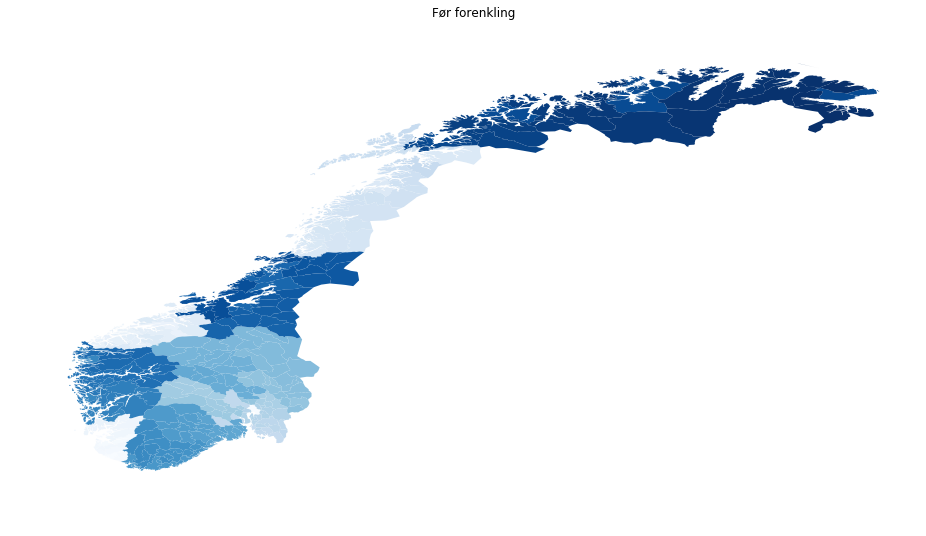

In [268]:
f, ax = plt.subplots(1, figsize=(16, 9))
ax.set_title('Før forenkling')
bg_combgm.plot(column='kommunenummer', cmap=plt.cm.Blues, ax=ax, k=7)
ax.set_axis_off()
plt.axis('equal');

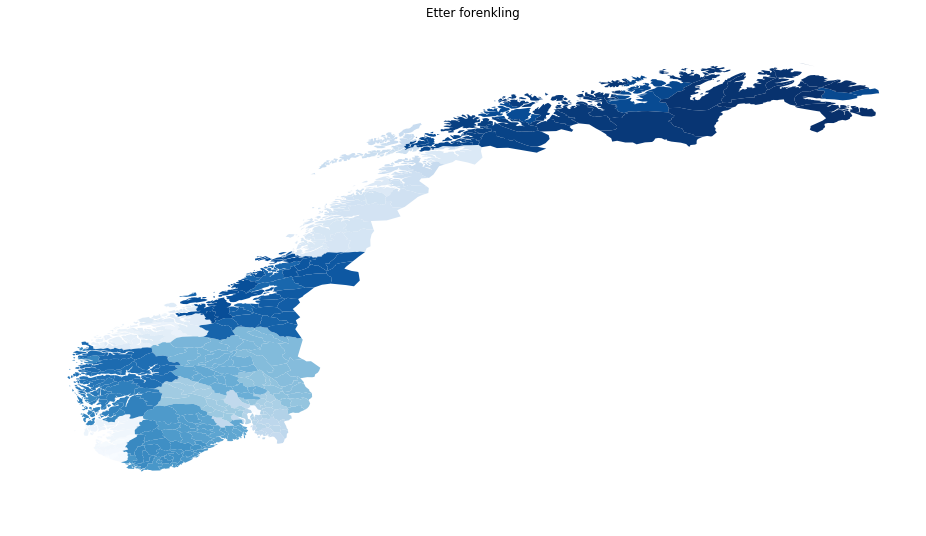

In [269]:
etter = gpd.read_file('data/2020/counties_2020_l_geojson.json')
f, ax = plt.subplots(1, figsize=(16, 9))
ax.set_title('Etter forenkling')
etter.plot(column='kommunenummer', cmap=plt.cm.Blues, ax=ax, k=7)
ax.set_axis_off()
plt.axis('equal');

In [270]:
DATA_LOC

'./data/2020/'

In [271]:
kart = bg_combgm[['fylke_navn','fylke_nummer','geometry']]
kart = kart.dissolve(by=['fylke_navn','fylke_nummer']).reset_index()
kart['area_fylke'] = kart.area
kart['centroid_fylke'] = kart.centroid

k = json.loads(kart.to_json(cls=jsonEncoder))
path = DATA_LOC + 'fylker_2020_geojson.json'
with open(path, 'w') as fp:
    json.dump(k, fp)
    
simplify('fylker_2020')

['[simplify] Repaired 18 intersections', '[o] Wrote data/2020/fylker_2020_s_geojson.json']
['[simplify] Repaired 18 intersections', '[o] Wrote data/2020/fylker_2020_m_geojson.json']
['[simplify] Repaired 6 intersections', '[o] Wrote data/2020/fylker_2020_l_geojson.json']
['[simplify] Repaired 3 intersections', '[o] Wrote data/2020/fylker_2020_xl_geojson.json']
['[o] Wrote data/2020/fylker_2020_xxl_geojson.json']


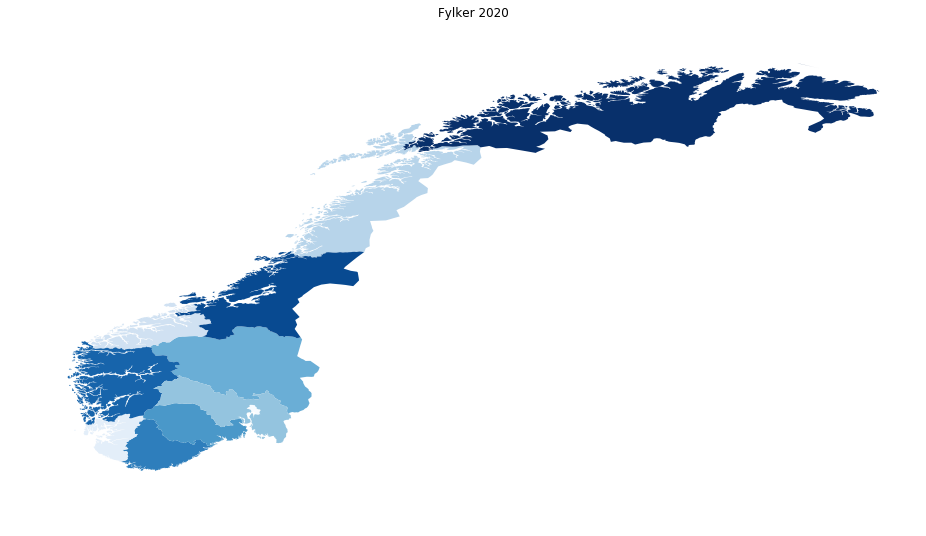

In [272]:
f, ax = plt.subplots(1, figsize=(16, 9))
ax.set_title('Fylker 2020')
kart.plot(column='fylke_nummer', cmap=plt.cm.Blues, ax=ax)
ax.set_axis_off()
plt.axis('equal');

In [273]:
kart = bg_combgm[['fylke_navn','fylke_nummer','geometry']]
kart = kart.dissolve(by=['fylke_navn','fylke_nummer']).reset_index()
kart['area_fylke'] = kart.area
kart['centroid_fylke'] = kart.centroid

k = json.loads(kart.to_json(cls=jsonEncoder))
path = DATA_LOC + 'fylker_2020_geojson.json'
with open(path, 'w') as fp:
    json.dump(k, fp)
    
simplify('fylker_2020')

['[simplify] Repaired 18 intersections', '[o] Wrote data/2020/fylker_2020_s_geojson.json']
['[simplify] Repaired 18 intersections', '[o] Wrote data/2020/fylker_2020_m_geojson.json']
['[simplify] Repaired 6 intersections', '[o] Wrote data/2020/fylker_2020_l_geojson.json']
['[simplify] Repaired 3 intersections', '[o] Wrote data/2020/fylker_2020_xl_geojson.json']
['[o] Wrote data/2020/fylker_2020_xxl_geojson.json']


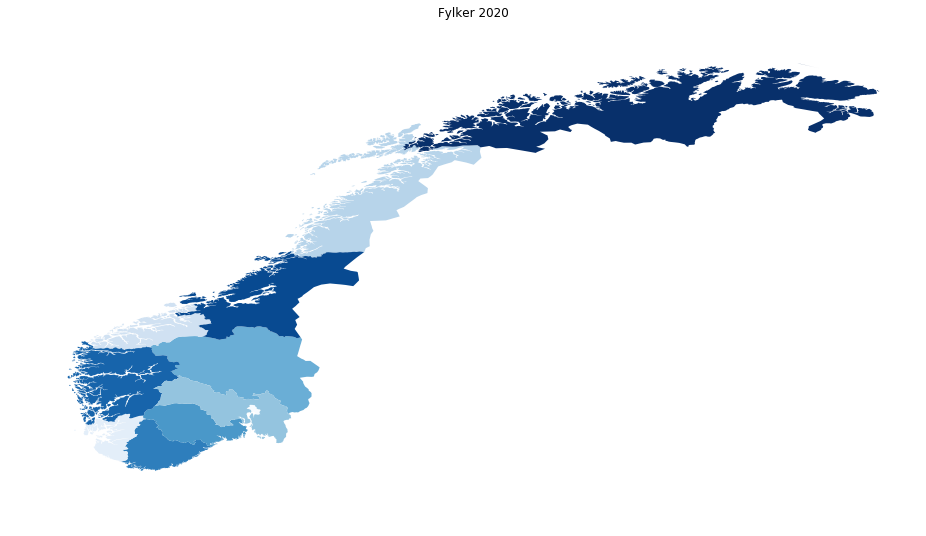

In [274]:
f, ax = plt.subplots(1, figsize=(16, 9))
ax.set_title('Fylker 2020')
kart.plot(column='fylke_nummer', cmap=plt.cm.Blues, ax=ax)
ax.set_axis_off()
plt.axis('equal');

In [275]:
kart.head()

,fylke_navn,fylke_nummer,geometry,area_fylke,centroid_fylke
0,AGDER,42,(POLYGON ((7.529018287242869 58.00040476006652...,2.527201,POINT (7.621109903277735 58.7006934245242)
1,INNLANDET,34,"POLYGON ((10.71184481568428 60.51604533603616,...",8.758690,POINT (10.42617627181988 61.44518482279759)
2,MØRE OG ROMSDAL,15,"(POLYGON ((5.363189206585209 62.2057678000961,...",2.477828,POINT (7.575444707350173 62.55970729726642)
3,NORDLAND,18,(POLYGON ((12.17935171797339 64.99031628903852...,7.697804,POINT (14.74269992469872 66.90717532709633)
4,OSLO,03,"POLYGON ((10.63605582795066 60.13375192234339,...",0.072515,POINT (10.73986591544763 59.98190898291021)


In [276]:
bg_combgm.head()

,kommunenummer,oppdateringsdato,navn,geometry,area_kommune,centroid_kommune,fylke_nummer,fylke_navn
0,0301,2019-10-28T00:00:00,Oslo,"POLYGON ((10.63605582795066 60.13375192234339,...",0.072515,POINT (10.73986591544763 59.98190898291021),03,OSLO
1,1101,2019-10-28T00:00:00,Eigersund,(POLYGON ((5.876816610090091 58.42534823517242...,0.066024,POINT (6.140947369482144 58.50157420291023),11,ROGALAND
2,1103,2019-10-28T00:00:00,Stavanger,"(POLYGON ((5.74912579368547 58.88467975716248,...",0.032018,POINT (5.813980981163446 59.11581611764877),11,ROGALAND
3,1106,2019-10-28T00:00:00,Haugesund,"POLYGON ((5.239613639164054 59.50250537386434,...",0.010756,POINT (5.302926031108083 59.4478551350085),11,ROGALAND
4,1108,2019-10-28T00:00:00,Sandnes,(POLYGON ((6.100411887943214 58.86604901450539...,0.161279,POINT (6.319274262192941 58.97915450977888),11,ROGALAND


In [277]:
bg_combgm[bg_combgm['kommunenummer']=='0301']

,kommunenummer,oppdateringsdato,navn,geometry,area_kommune,centroid_kommune,fylke_nummer,fylke_navn
0,0301,2019-10-28T00:00:00,Oslo,"POLYGON ((10.63605582795066 60.13375192234339,...",0.072515,POINT (10.73986591544763 59.98190898291021),03,OSLO


In [278]:
def getFylker(fylke, år):
    kart = bg_combgm[bg_combgm[f'fylke_nummer']==fylke]

    k = json.loads(kart.to_json(cls=jsonEncoder))
    path = DATA_LOC + f'fylke_{fylke}_2020_geojson.json'
    with open(path, 'w') as fp:
        json.dump(k, fp)

    simplify(f'fylke_{fylke}_{år}')

In [279]:
fylker_2020 = bg_combgm['fylke_nummer'].unique()
fylker_2020

array(['03', '11', '15', '18', '30', '34', '38', '42', '46', '50', '54'],
      dtype=object)

In [280]:
for fylke in fylker_2020:
    getFylker(fylke,'2020')

['[o] Wrote data/2020/fylke_03_2020_s_geojson.json']
['[o] Wrote data/2020/fylke_03_2020_m_geojson.json']
['[o] Wrote data/2020/fylke_03_2020_l_geojson.json']
['[o] Wrote data/2020/fylke_03_2020_xl_geojson.json']
['[o] Wrote data/2020/fylke_03_2020_xxl_geojson.json']
['[simplify] Repaired 1 intersection', '[o] Wrote data/2020/fylke_11_2020_s_geojson.json']
['[o] Wrote data/2020/fylke_11_2020_m_geojson.json']
['[o] Wrote data/2020/fylke_11_2020_l_geojson.json']
['[simplify] Repaired 2 intersections', '[o] Wrote data/2020/fylke_11_2020_xl_geojson.json']
['[o] Wrote data/2020/fylke_11_2020_xxl_geojson.json']
['[simplify] Repaired 4 intersections', '[o] Wrote data/2020/fylke_15_2020_s_geojson.json']
['[o] Wrote data/2020/fylke_15_2020_m_geojson.json']
['[simplify] Repaired 2 intersections', '[o] Wrote data/2020/fylke_15_2020_l_geojson.json']
['[o] Wrote data/2020/fylke_15_2020_xl_geojson.json']
['[o] Wrote data/2020/fylke_15_2020_xxl_geojson.json']
['[simplify] Repaired 2 intersections', '

In [281]:
def plotkart(kart):
    f, ax = plt.subplots(1, figsize=(16, 9))
    ax.set_title('Fylker 2020')
    kart.plot(column='kommunenummer', cmap=plt.cm.Blues, ax=ax)
    ax.set_axis_off()
    plt.axis('equal');

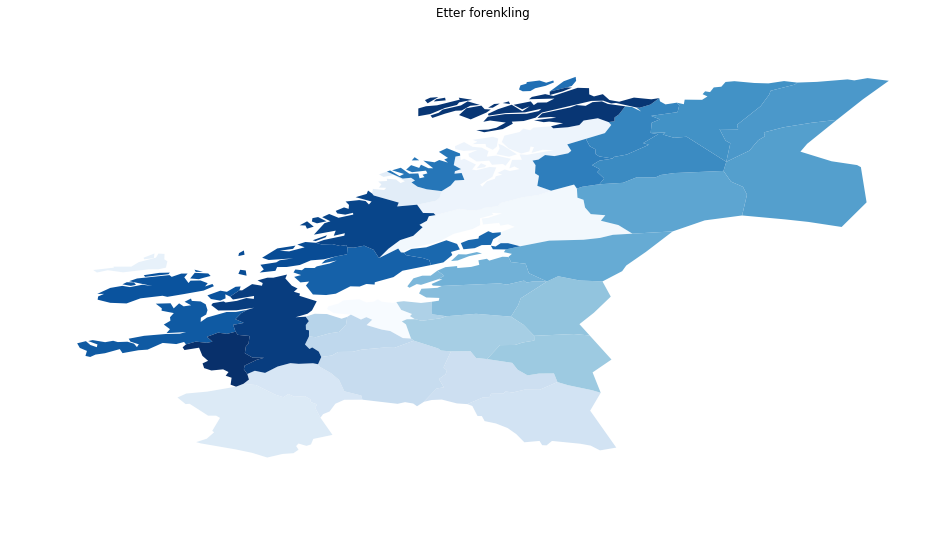

In [282]:
etter = gpd.read_file('data/2020/fylke_50_2020_xl_geojson.json')
f, ax = plt.subplots(1, figsize=(16, 9))
ax.set_title('Etter forenkling')
etter.plot(column='kommunenummer', cmap=plt.cm.Blues, ax=ax, k=7)
ax.set_axis_off()
plt.axis('equal');

# Generate some dummy data

In [283]:
def to_json_file(df, path):
    with open(path, 'w') as fp:
        recs = df.to_json(orient='records')
        json.dump(recs, fp)

In [284]:
import random

def getColor():
    r = int(random.random() * 256) 
    g = int(random.random() * 256) 
    b = int(random.random() * 256) 
    return ([r,g,b]) 

In [285]:
data = []
for k in bg_combgm['kommunenummer'].unique():
    data.append([k, random.randint(1,101), getColor()])
    
df = pd.DataFrame(data)
df.columns = ['kommunenummer', 'value', 'color']
df.to_csv(DATA_LOC + 'kommune_dummy_data.csv', index=False)
to_json_file(df, DATA_LOC + 'kommune_dummy_data.json')

In [286]:
data = []
for k in bg_combgm['fylke_nummer'].unique():
    data.append([k, random.randint(1,101), getColor()])
    
df = pd.DataFrame(data)
df.columns = ['fylke_nummer_2020', 'value', 'color']
df.to_csv(DATA_LOC + 'fylke_2020_dummy_data.csv', index=False)
to_json_file(df, DATA_LOC + 'fylke_2020_dummy_data.json')

In [287]:
df.to_json(orient='records')

'[{"fylke_nummer_2020":"03","value":26,"color":[158,8,191]},{"fylke_nummer_2020":"11","value":43,"color":[63,183,251]},{"fylke_nummer_2020":"15","value":64,"color":[162,18,245]},{"fylke_nummer_2020":"18","value":19,"color":[50,16,19]},{"fylke_nummer_2020":"30","value":56,"color":[133,180,20]},{"fylke_nummer_2020":"34","value":55,"color":[145,144,173]},{"fylke_nummer_2020":"38","value":23,"color":[220,118,120]},{"fylke_nummer_2020":"42","value":27,"color":[34,247,208]},{"fylke_nummer_2020":"46","value":98,"color":[41,30,163]},{"fylke_nummer_2020":"50","value":93,"color":[177,209,41]},{"fylke_nummer_2020":"54","value":92,"color":[236,193,169]}]'